In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import glob
import numpy as np
import cv2

2025-05-24 14:45:03.487546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748097903.732778      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748097903.799338      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1]
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    scale = Add()([avg_pool, max_pool])
    return Multiply()([inputs, scale])


In [3]:
def unet_cam(input_shape=(256, 512, 3), num_classes=34):
    # Encoder (ResNet50 Backbone)
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Feature Extraction
    s1 = base_model.get_layer('conv1_relu').output       # 128x256
    s2 = base_model.get_layer('conv2_block3_out').output # 64x128
    s3 = base_model.get_layer('conv3_block4_out').output # 32x64
    s4 = base_model.get_layer('conv4_block6_out').output # 16x32

    # Decoder with Channel Attention only
    d1 = UpSampling2D(2)(s4)  # 32x64
    d1 = concatenate([d1, s3])
    d1 = Conv2D(512, 3, padding='same', activation='relu')(d1)
    d1 = channel_attention(d1)

    d2 = UpSampling2D(2)(d1)  # 64x128
    d2 = concatenate([d2, s2])
    d2 = Conv2D(256, 3, padding='same', activation='relu')(d2)
    d2 = channel_attention(d2)

    d3 = UpSampling2D(2)(d2)  # 128x256
    d3 = concatenate([d3, s1])
    d3 = Conv2D(128, 3, padding='same', activation='relu')(d3)
    d3 = channel_attention(d3)

    # Final Upsampling to Original Resolution
    d4 = UpSampling2D(2)(d3)  # 256x512
    outputs = Conv2D(num_classes, 1, activation='softmax')(d4)

    return Model(inputs=base_model.input, outputs=outputs)


In [4]:
# ======================================================
# Dataset Preparation
# ======================================================
def create_dataset(img_paths, label_paths, batch_size=8, shuffle=True):
    def process_path(img_path, label_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (256, 512))
        img = tf.cast(img, tf.float32) / 127.5 - 1
        
        label = tf.io.read_file(label_path)
        label = tf.image.decode_png(label, channels=1)
        label = tf.image.resize(label, (256, 512), method='nearest')
        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, label_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [5]:
# Dataset preparation
img = glob.glob('../input/cityscapes/Cityspaces/images/train/*/*.png')
label = glob.glob('../input/cityscapes/Cityspaces/gtFine/train/*/*_gtFine_labelIds.png')

img = sorted(img)
label = sorted(label)

# Debug: Check dataset sizes
print(f"Number of images: {len(img)}")
print(f"Number of labels: {len(label)}")

# Create matching image-label pairs
paired = [(i, l) for i, l in zip(img, label) 
          if i.split('/')[-1].split('_leftImg8bit')[0] == l.split('/')[-1].split('_gtFine_labelIds')[0]]

img, label = zip(*paired)

img = list(img)
label = list(label)


# Create datasets
train_ds = create_dataset(img, label, shuffle=True)

# Dataset preparation
val_img = glob.glob('../input/cityscapes/Cityspaces/images/val/*/*.png')
val_label = glob.glob('../input/cityscapes/Cityspaces/gtFine/val/*/*_gtFine_labelIds.png')

val_img = sorted(val_img)
val_label = sorted(val_label)

# Debug: Check dataset sizes
print(f"Number of images: {len(val_img)}")
print(f"Number of labels: {len(val_label)}")

# Create matching image-label pairs
paired = [(i, l) for i, l in zip(img, label) 
          if i.split('/')[-1].split('_leftImg8bit')[0] == l.split('/')[-1].split('_gtFine_labelIds')[0]]

val_img, val_label = zip(*paired)

val_img = list(val_img)
val_label = list(val_label)


val_ds = create_dataset(val_img, val_label)

# Debug: Test dataset creation
for images, masks in train_ds.take(1):
    print("Train batch - Images shape:", images.shape)
    print("Train batch - Masks shape:", masks.shape)

Number of images: 2975
Number of labels: 2975


I0000 00:00:1748097925.004082      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Number of images: 500
Number of labels: 500
Train batch - Images shape: (8, 256, 512, 3)
Train batch - Masks shape: (8, 256, 512, 1)


In [6]:
from tensorflow.keras.metrics import MeanIoU

# ======================================================
# Custom mIoU Metric with Argmax preprocessing
# ======================================================
class ArgmaxMeanIoU(MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# ======================================================
# Model Compilation with Fixed Metrics
# ======================================================
model = unet_cam()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', ArgmaxMeanIoU(num_classes=34)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
# Learning Rate Schedule
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[lr_scheduler]
)

Epoch 1/50


I0000 00:00:1748098030.069531      56 service.cc:148] XLA service 0x7d9cac0020f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748098030.070495      56 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1748098032.615048      56 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1748098034.460888      56 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748098065.750269      56 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


371/372 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7310 - loss: 1.1017 - mean_iou: 0.1608

W0000 00:00:1748098158.546189      56 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7312 - loss: 1.1007 - mean_iou: 0.1610

W0000 00:00:1748098217.306682      58 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748098282.834569      57 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


372/372 ━━━━━━━━━━━━━━━━━━━━ 327s 599ms/step - accuracy: 0.7314 - loss: 1.0998 - mean_iou: 0.1611 - val_accuracy: 0.4975 - val_loss: 2.0234 - val_mean_iou: 0.0539 - learning_rate: 1.0000e-04
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 197s 465ms/step - accuracy: 0.8530 - loss: 0.4915 - mean_iou: 0.2883 - val_accuracy: 0.7612 - val_loss: 0.8184 - val_mean_iou: 0.2126 - learning_rate: 1.0000e-04
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 197s 464ms/step - accuracy: 0.8720 - loss: 0.4076 - mean_iou: 0.3616 - val_accuracy: 0.8666 - val_loss: 0.4110 - val_mean_iou: 0.3831 - learning_rate: 1.0000e-04
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 196s 462ms/step - accuracy: 0.8832 - loss: 0.3629 - mean_iou: 0.4062 - val_accuracy: 0.8925 - val_loss: 0.3301 - val_mean_iou: 0.4503 - learning_rate: 1.0000e-04
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 197s 464ms/step - accuracy: 0.8936 - loss: 0.3231 - mean_iou: 0.4469 - val_accuracy: 0.8989 - val_loss: 0.3041 - val_mean_iou: 0.4917 - learning_rate: 1.0000e-04
E

In [8]:
model.save('cityscapes_unet_cam.keras') 

In [9]:
import matplotlib.pyplot as plt
# ======================================================
# Prediction
# ======================================================
def visualize_prediction(image_path):
    img = cv2.imread(image_path)
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(original, (512, 256))
    normalized = (resized / 127.5) - 1.0
    
    pred = model.predict(tf.expand_dims(normalized, 0))
    pred_mask = tf.argmax(pred[0], axis=-1).numpy().astype(np.uint8)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(121); plt.imshow(resized)
    plt.subplot(122); plt.imshow(pred_mask)
    plt.show()

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Create subplots
    plt.figure(figsize=(15, 5))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot mIoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_iou'], label='Train mIoU')
    plt.plot(history.history['val_mean_iou'], label='Val mIoU')
    plt.title('Training and Validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.grid(True)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


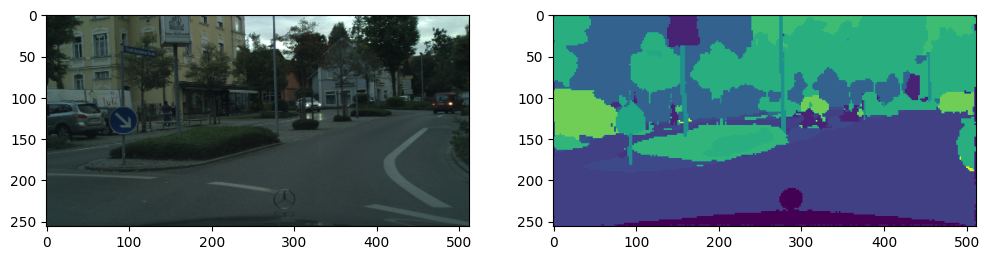

In [11]:
visualize_prediction("/kaggle/input/cityscapes/Cityspaces/images/val/lindau/lindau_000009_000019_leftImg8bit.png")

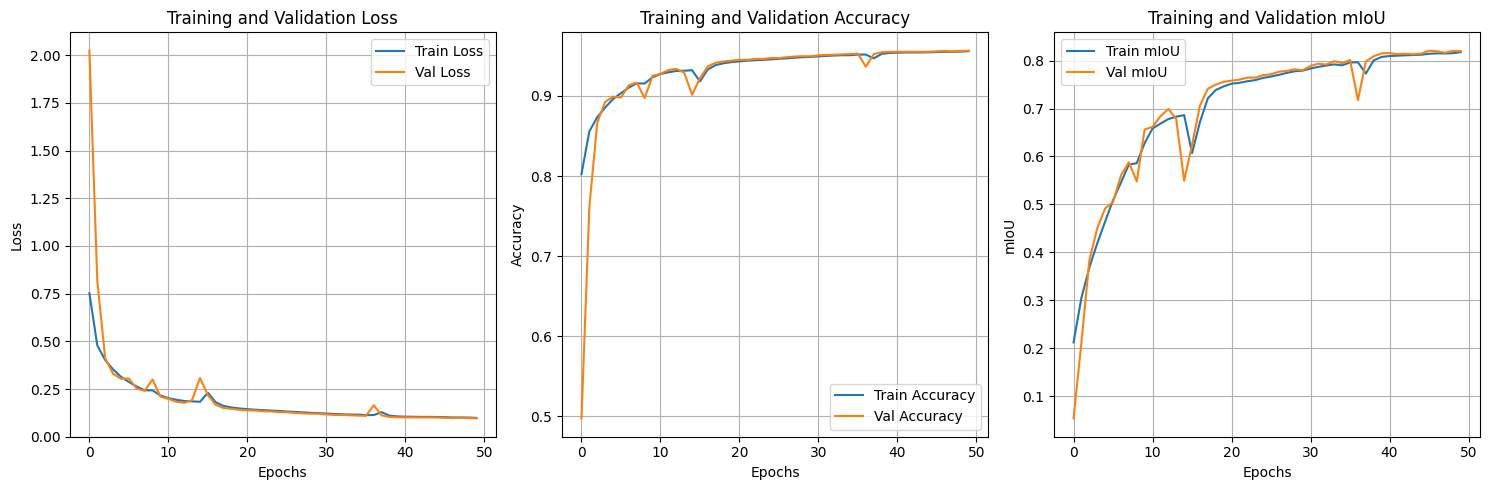

In [12]:
def plot_training_history(history):
    # Create subplots
    plt.figure(figsize=(15, 5))
    
    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot mIoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_iou'], label='Train mIoU')
    plt.plot(history.history['val_mean_iou'], label='Val mIoU')
    plt.title('Training and Validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# After training, call the function with your history object
plot_training_history(history)
